c:\Users\Monis\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0
[Epoch 1, Batch 100] loss: 0.697
[Epoch 1, Batch 200] loss: 0.693
[Epoch 2, Batch 100] loss: 0.693
[Epoch 2, Batch 200] loss: 0.693
[Epoch 3, Batch 100] loss: 0.693
[Epoch 3, Batch 200] loss: 0.693
Overall Accuracy: 0.9333

Confusion Matrix for Class 0:
[[1192    0]
 [  31    0]]
Class 0 Metrics:
 - Precision: 0.9747
 - Recall: 1.0000
 - F1 Score: 0.9872
 - Accuracy: 0.9747


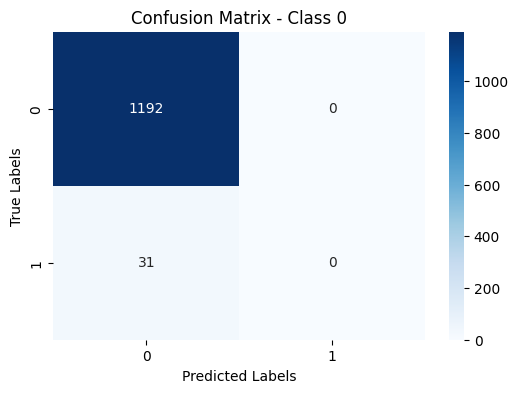


Confusion Matrix for Class 1:
[[1155    0]
 [  68    0]]
Class 1 Metrics:
 - Precision: 0.9444
 - Recall: 1.0000
 - F1 Score: 0.9714
 - Accuracy: 0.9444


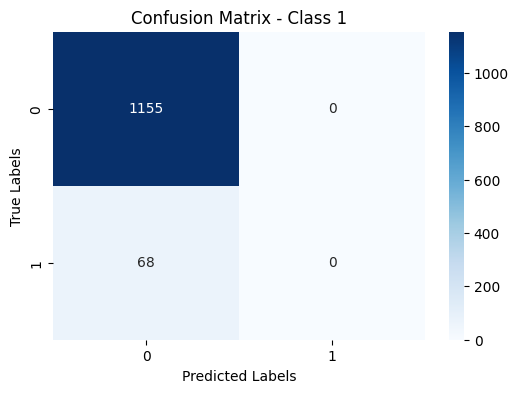


Confusion Matrix for Class 2:
[[1157    0]
 [  66    0]]
Class 2 Metrics:
 - Precision: 0.9460
 - Recall: 1.0000
 - F1 Score: 0.9723
 - Accuracy: 0.9460


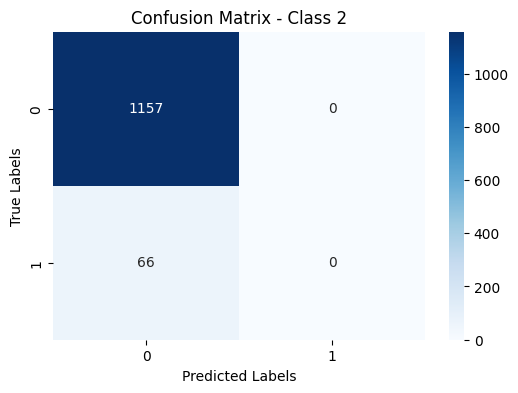


Confusion Matrix for Class 3:
[[1205    0]
 [  18    0]]
Class 3 Metrics:
 - Precision: 0.9853
 - Recall: 1.0000
 - F1 Score: 0.9926
 - Accuracy: 0.9853


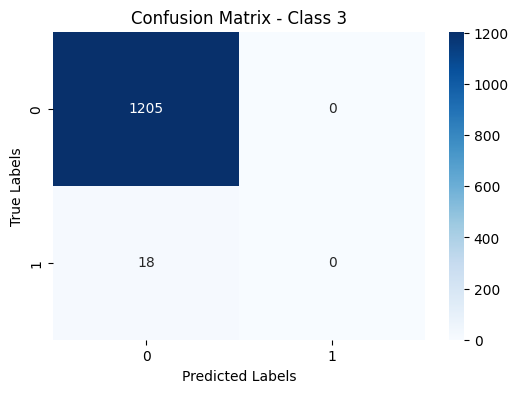


Confusion Matrix for Class 4:
[[1171    0]
 [  52    0]]
Class 4 Metrics:
 - Precision: 0.9575
 - Recall: 1.0000
 - F1 Score: 0.9783
 - Accuracy: 0.9575


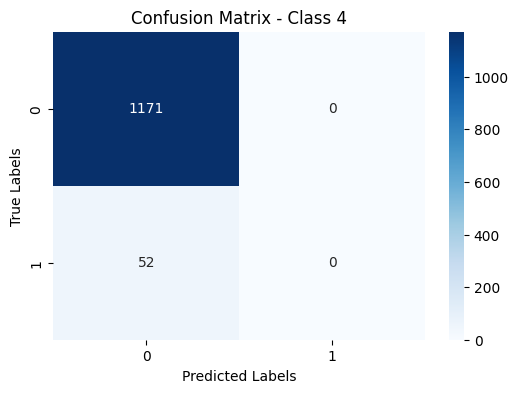


Confusion Matrix for Class 5:
[[1147    0]
 [  76    0]]
Class 5 Metrics:
 - Precision: 0.9379
 - Recall: 1.0000
 - F1 Score: 0.9679
 - Accuracy: 0.9379


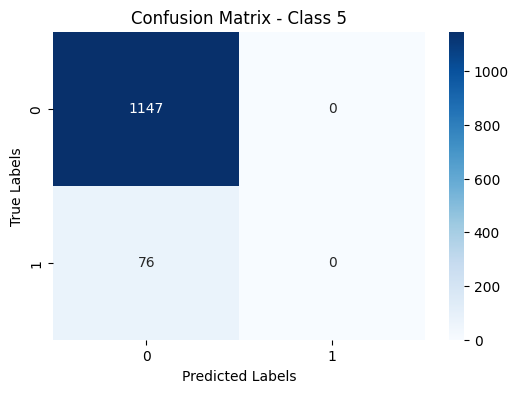


Confusion Matrix for Class 6:
[[814   0]
 [409   0]]
Class 6 Metrics:
 - Precision: 0.6656
 - Recall: 1.0000
 - F1 Score: 0.7992
 - Accuracy: 0.6656


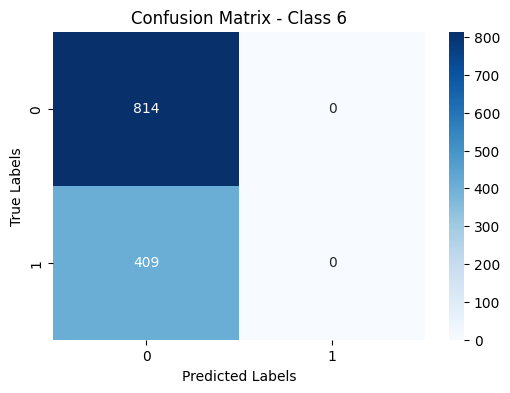


Confusion Matrix for Class 7:
[[1188    0]
 [  35    0]]
Class 7 Metrics:
 - Precision: 0.9714
 - Recall: 1.0000
 - F1 Score: 0.9855
 - Accuracy: 0.9714


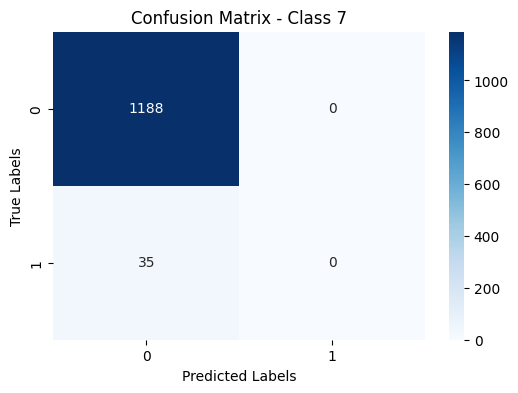


Confusion Matrix for Class 8:
[[1185    0]
 [  38    0]]
Class 8 Metrics:
 - Precision: 0.9689
 - Recall: 1.0000
 - F1 Score: 0.9842
 - Accuracy: 0.9689


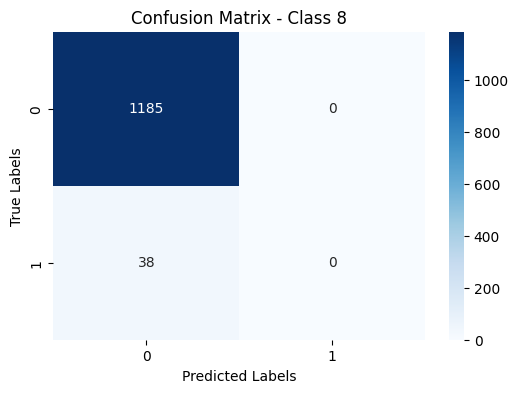


Confusion Matrix for Class 9:
[[1116    0]
 [ 107    0]]
Class 9 Metrics:
 - Precision: 0.9125
 - Recall: 1.0000
 - F1 Score: 0.9543
 - Accuracy: 0.9125


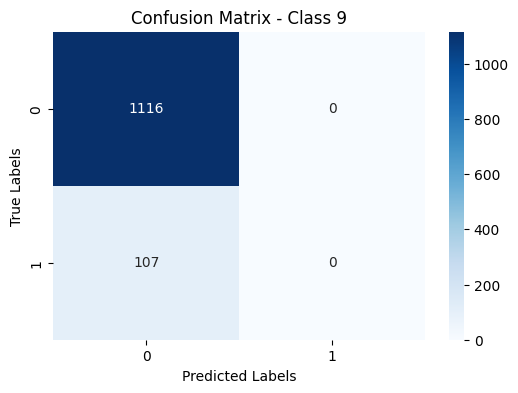


Confusion Matrix for Class 10:
[[1117    0]
 [ 106    0]]
Class 10 Metrics:
 - Precision: 0.9133
 - Recall: 1.0000
 - F1 Score: 0.9547
 - Accuracy: 0.9133


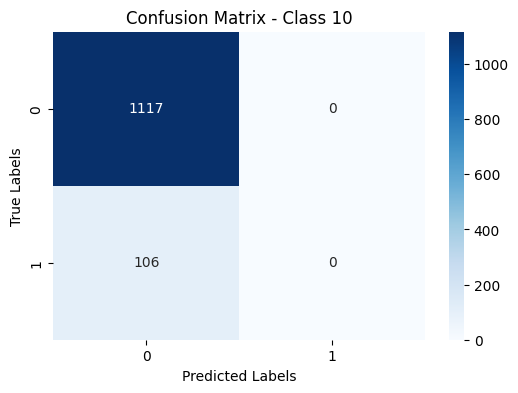


Confusion Matrix for Class 11:
[[1206    0]
 [  17    0]]
Class 11 Metrics:
 - Precision: 0.9861
 - Recall: 1.0000
 - F1 Score: 0.9930
 - Accuracy: 0.9861


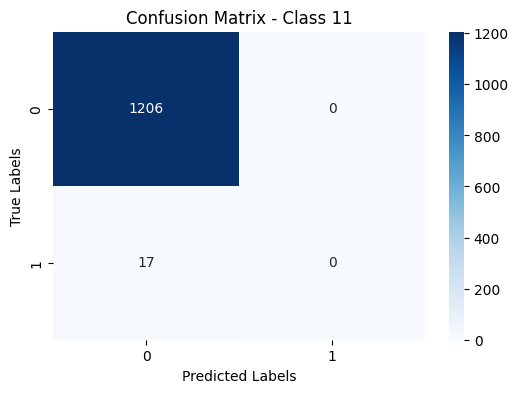


Confusion Matrix for Class 12:
[[1063    0]
 [ 160    0]]
Class 12 Metrics:
 - Precision: 0.8692
 - Recall: 1.0000
 - F1 Score: 0.9300
 - Accuracy: 0.8692


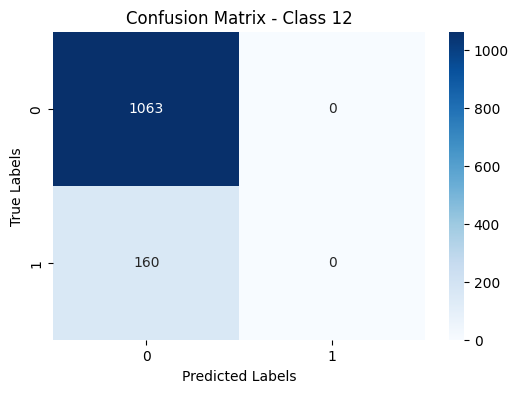


Confusion Matrix for Class 13:
[[1213    0]
 [  10    0]]
Class 13 Metrics:
 - Precision: 0.9918
 - Recall: 1.0000
 - F1 Score: 0.9959
 - Accuracy: 0.9918


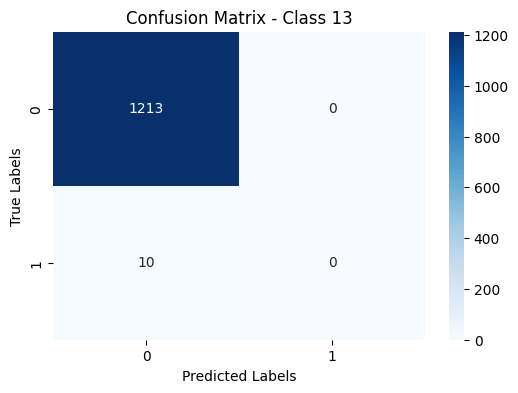


Confusion Matrix for Class 14:
[[1193    0]
 [  30    0]]
Class 14 Metrics:
 - Precision: 0.9755
 - Recall: 1.0000
 - F1 Score: 0.9876
 - Accuracy: 0.9755


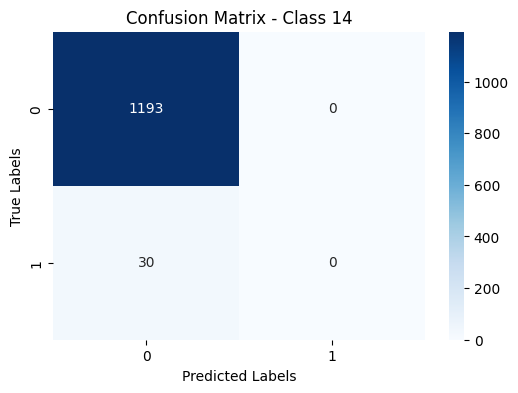

Macro-average Precision: 1.0000, Recall: 0.0000, F1 Score: 0.0000
Micro-average Precision: 1.0000, Recall: 0.0000, F1 Score: 0.0000


In [1]:
#Adaptive weight ensemble
#Ensemble of inceptionresnetv2 +Desnet201 +ResNet50V2 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from PIL import Image
import gc
from sklearn.utils.class_weight import compute_class_weight
import torch.multiprocessing as mp
from timm import create_model   
import seaborn as sns

mp.set_start_method('spawn', force=True)


# Define the custom dataset path
dataset_path = './split2'

# Transformations for the data (Optional Code is not utilized)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ResNet50v2
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

import os
import numpy as np

def preprocess_image(image):
    try:
        # Resize the image to 224x224 (as required by ResNet50v2)
        image = image.resize((224, 224))
        
        # Convert image from PIL to OpenCV format (BGR)
        image = np.array(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Convert BGR to Lab
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        
        # Split the LAB image into its channels
        l_channel, a_channel, b_channel = cv2.split(lab_image)
        
        # Apply CLAHE to L-channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_channel = clahe.apply(l_channel)
        
        # Merge the channels back
        lab_image = cv2.merge((l_channel, a_channel, b_channel))
        
        # Convert Lab back to BGR
        bgr_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
        
        # Apply Adaptive Median Filter (Optional)
        bgr_image = cv2.medianBlur(bgr_image, ksize=3)
        
        # Apply Gamma Correction (Optional)
        gamma = 1.2
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        bgr_image = cv2.LUT(bgr_image, table)
        
        # Convert back to PIL format and then to tensor
        image = Image.fromarray(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB))
        
        # Convert image to numpy array and normalize to -1 to +1
        image = np.array(image).astype(np.float32)
        image = (image / 127.5) - 1.0
        
        # Ensure the output shape is correct
        if image.shape != (224, 224, 3):  # Update shape for ResNet50v2
            raise ValueError(f"Image shape is {image.shape}, expected (224, 224, 3)")
        
        # Convert to tensor
        image = torch.from_numpy(image).permute(2, 0, 1)  # Shape: (3, 224, 224)
        
        return image
    except Exception as e:
        print(f"Error in preprocessing image: {e}")
        return None


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, num_classes=15, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.num_classes = num_classes
        self.images = []
        self.labels = []

        for label, class_dir in enumerate(os.listdir(image_folder)):
            class_path = os.path.join(image_folder, class_dir)
            for img_file in os.listdir(class_path):
                self.images.append(os.path.join(class_path, img_file))
                
                # Convert class label into a one-hot binary vector (1-vs-All)
                binary_label = np.zeros(num_classes)
                binary_label[label] = 1  # Set 1 for the corresponding class
                self.labels.append(binary_label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        image = preprocess_image(image)
        if image is None:
            raise ValueError(f"Failed to preprocess image at index {idx}")

        # Keep labels as a binary vector instead of a single class index
        label = torch.tensor(self.labels[idx], dtype=torch.float32)  # One-hot encoded labels

        return image, label  # Returns binary vector labels for BCEWithLogitsLoss




# Load custom dataset
trainset = CustomDataset(dataset_path + '/Train')
testset = CustomDataset(dataset_path + '/Test')

# Define the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

inception_resnet_v2 = create_model('inception_resnet_v2', pretrained=True, num_classes=0)  # InceptionResNetV2 model
densenet201 = create_model('densenet201', pretrained=True, num_classes=0)  # DenseNet201 model
resnet50v2 = create_model('resnet50', pretrained=True, num_classes=0)  # ResNet50V2 model

# Move models to device
inception_resnet_v2.to(device)
densenet201.to(device)
resnet50v2.to(device)

class OneVsAllEnsembleModel(nn.Module):
    def __init__(self, inception_resnet_v2, densenet201, resnet50v2, num_classes=15):
        super(OneVsAllEnsembleModel, self).__init__()
        self.num_classes = num_classes
        self.inception_resnet_v2 = inception_resnet_v2
        self.densenet201 = densenet201
        self.resnet50v2 = resnet50v2

        # Define common feature dimension for all models
        common_feature_size = 1024

        # Project features to the common size
        self.inception_resnet_proj = nn.Linear(inception_resnet_v2.num_features, common_feature_size)
        self.densenet_proj = nn.Linear(densenet201.num_features, common_feature_size)
        self.resnet_proj = nn.Linear(resnet50v2.num_features, common_feature_size)

        # Fully connected layers for each class (One-vs-All)
        self.fc_layers = nn.ModuleList([nn.Linear(common_feature_size, 1) for _ in range(num_classes)])

    def forward(self, x):
        features_inception_resnet = self.inception_resnet_proj(self.inception_resnet_v2(x).view(x.size(0), -1))
        features_densenet = self.densenet_proj(self.densenet201(x).view(x.size(0), -1))
        features_resnet50v2 = self.resnet_proj(self.resnet50v2(x).view(x.size(0), -1))

        # Apply equal weighting to each model’s features
        weighted_features = (features_inception_resnet + features_densenet + features_resnet50v2) / 3

        # **Use Sigmoid Activation for Each Class for Independent Binary Classification**
        outputs = [torch.sigmoid(fc(weighted_features)) for fc in self.fc_layers]

        return torch.cat(outputs, dim=1)  # Shape: (batch_size, num_classes)



# Instantiate the ensemble model
ensemble_model = OneVsAllEnsembleModel(inception_resnet_v2, densenet201, resnet50v2)
ensemble_model.to(device)
 

# Define the loss function and optimizer
train_labels = [label for _, label in trainset]


criterion =nn.BCEWithLogitsLoss()

optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

# Use mixed precision training
scaler = torch.amp.GradScaler('cuda')


def train_model(model, trainloader, criterion, optimizer, scaler, epochs=2):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                outputs = model(inputs)  # Shape: (batch_size, num_classes)
                loss = criterion(outputs, labels)  # Multi-label binary classification loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0


# Evaluate the model
# Evaluate the model
def evaluate_model(model, testloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, data in enumerate(testloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).int()  # Apply threshold at 0.5 for binary classification

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Compute accuracy
    accuracy = accuracy_score(all_labels.flatten(), all_predictions.flatten())
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Compute precision, recall, F1-score for each class
    for i in range(all_labels.shape[1]):  # Loop over each class
        # Calculate confusion matrix for each class
        conf_matrix = confusion_matrix(all_labels[:, i], all_predictions[:, i])
        print(f"\nConfusion Matrix for Class {i}:")
        print(conf_matrix)

        # Calculate Precision, Recall, F1 Score, and Accuracy per class
        precision = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0]) 
        recall = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 1]) 
        f1 = 2 * (precision * recall) / (precision + recall) 
        accuracy_class = (conf_matrix[0, 0] + conf_matrix[1, 1]) / (conf_matrix[0, 0] + conf_matrix[0, 1]+conf_matrix[1, 0] + conf_matrix[1, 1])  # Accuracy per class

        print(f"Class {i} Metrics:")
        print(f" - Precision: {precision:.4f}")
        print(f" - Recall: {recall:.4f}")
        print(f" - F1 Score: {f1:.4f}")
        print(f" - Accuracy: {accuracy_class:.4f}")

        # Visualize the confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.title(f'Confusion Matrix - Class {i}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    # Compute macro-average precision, recall, and F1-score across all classes
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro', zero_division=1)
    print(f"Macro-average Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Optionally, you could compute micro-average as well, which treats all instances as if they were from a single class
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(all_labels, all_predictions, average='micro', zero_division=1)
    print(f"Micro-average Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1 Score: {f1_micro:.4f}")




# Train and evaluate
train_model(ensemble_model, trainloader, criterion, optimizer, scaler, epochs=3)
evaluate_model(ensemble_model, testloader)

# Free GPU memory
torch.cuda.empty_cache()

# Explicitly delete model and other tensors on the GPU
del ensemble_model
del trainloader
del testloader
del criterion
del optimizer
del scaler

# Force a garbage collection to clean up any remaining objects
gc.collect()

# Final GPU memory cleanup
torch.cuda.empty_cache()


In [1]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device found")
print("PyTorch CUDA Version:", torch.version.cuda)
print("Torch version:", torch.__version__)


CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 3090 Ti
PyTorch CUDA Version: 12.4
Torch version: 2.4.0+cu124
